In [1]:
import numpy as np
import matplotlib.pyplot as plt

from jupyterthemes import jtplot
jtplot.style(theme = "monokai",context = "notebook", ticks = True,grid = False)

arms = 5;
true_exp_val = [0.2,0.3,0.8,0.25,0.1];

In [2]:
#helper functions
def bernoulli(exp_val):
    reward = 1 if np.random.random() < exp_val else 0
#     reward = np.random.normal(exp_val,0.01)
    return(reward)
    
def softmax_tau(arr,tau):
    return np.exp(arr/tau)/np.sum(np.exp(arr/tau))    
    
class bernoulli_bandits(object):
    def __init__(self,k,true_exp_val):
        self.num_arms = k
        self.exp_val = true_exp_val
        self.emp_mean = np.ones(k)
        self.opt_arm = np.argmax(self.exp_val)
        self.opt_exp_val = np.max(self.exp_val)
        self.a = np.ones(k)
        self.b = np.ones(k)

# $\epsilon$  - greedy fixed

In [3]:
class eps_greedy_fixed(object):
    def __init__(self,eps,n,num_arms):
        self.eps = eps
        self.num_iter = n
        self.num_arms_picks = np.zeros(num_arms)
    
    def update_emp_mean(self,emp_mean,reward,arm):
        self.num_arms_picks[arm] += 1;
        emp_mean += (reward - emp_mean)/self.num_arms_picks[arm]
        return emp_mean
        
    def run_experiment(self,emp_mean,opt_arm,opt_exp_val,exp_val):
        regret_per_turn = []
        opt_arm_plays = 0
        per_opt_arm_plays = []
        
        for iters in range(self.num_iter):
            rand = np.random.random()
            
            if rand < 1 - self.eps:
                action = np.argmax(emp_mean)
            else:
                action = np.random.choice(len(emp_mean))
                
            rew = bernoulli(exp_val[action])
            emp_mean[action] = self.update_emp_mean(emp_mean[action],rew,action)
            regret_per_turn.append(opt_exp_val - exp_val[action])
            
            if action == opt_arm:
                opt_arm_plays += 1
            per_opt_arm_plays.append(opt_arm_plays/(iters+1))
            
        return(regret_per_turn,per_opt_arm_plays)

In [4]:
epsf = [0.005,0.001,0.01,0.05,0.1]
epsf_dict = {}

for vals in epsf:
    rpt_epsf = np.zeros(10000)
    poap_epsf = np.zeros(10000)
    for sims in range(100):
        epsf = eps_greedy_fixed(vals,10000,arms)
        bandit = bernoulli_bandits(arms,true_exp_val)
        tmp1,tmp2 = epsf.run_experiment(bandit.emp_mean,bandit.opt_arm,bandit.opt_exp_val,bandit.exp_val)
        rpt_epsf = np.add(rpt_epsf,tmp1)
        poap_epsf = np.add(poap_epsf,tmp2)
        
    epsf_dict[vals] = [rpt_epsf/100,poap_epsf/100]

In [5]:
epsf_dict.keys()

dict_keys([0.005, 0.001, 0.01, 0.05, 0.1])

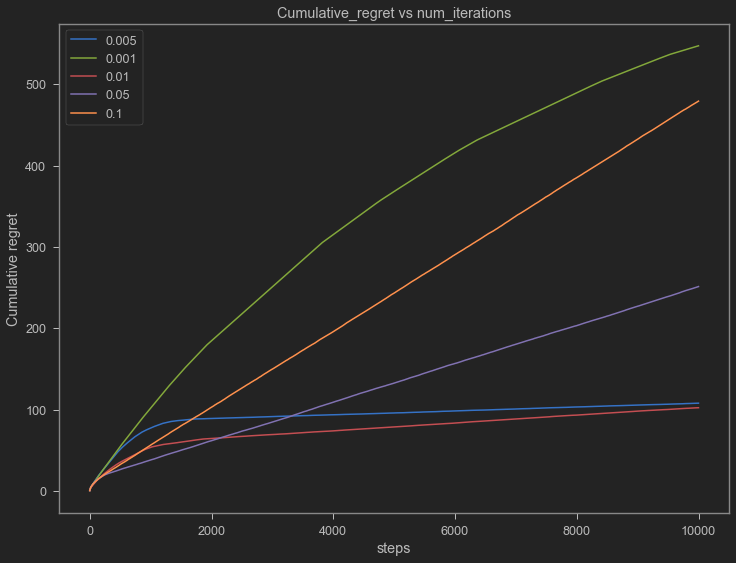

In [6]:
plt.figure(figsize=(12,9))
plt.title("Cumulative_regret vs num_iterations")
for keys in epsf_dict: 
    plt.plot(np.cumsum(epsf_dict[keys][0]),label=keys);
plt.legend();
plt.xlabel("steps");
plt.ylabel("Cumulative regret");
# plt.savefig("epsf1")

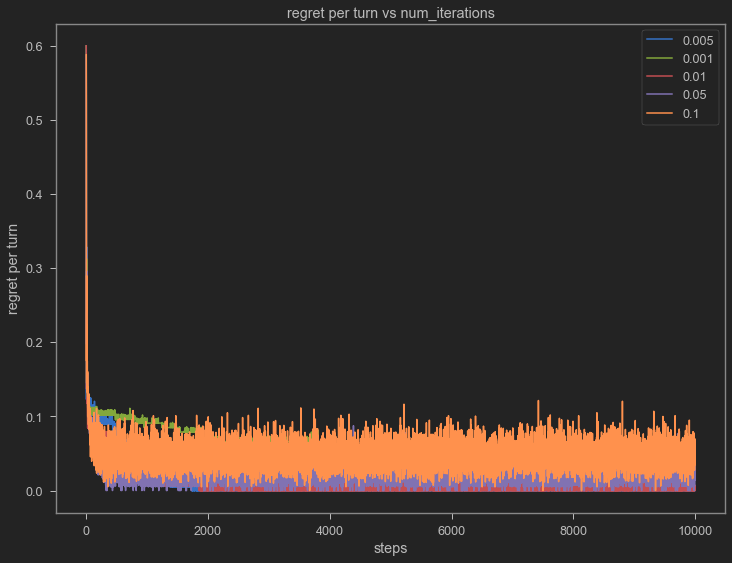

In [7]:
plt.figure(figsize=(12,9))
plt.title("regret per turn vs num_iterations")
for keys in epsf_dict: 
    plt.plot(epsf_dict[keys][0],label=keys);
plt.legend();
plt.xlabel("steps");
plt.ylabel("regret per turn");
# plt.savefig("epsf2")

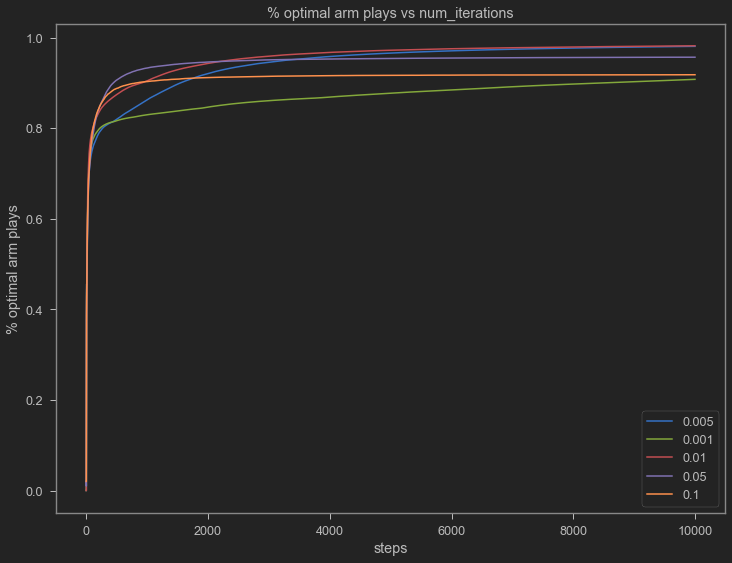

In [8]:
plt.figure(figsize=(12,9))
plt.title("% optimal arm plays vs num_iterations")
for keys in epsf_dict: 
    plt.plot(epsf_dict[keys][1],label=keys);
plt.legend()
plt.xlabel("steps");

plt.ylabel("% optimal arm plays");
# plt.savefig("epsf3")

# $\epsilon$  - greedy variable

In [9]:
class eps_greedy_variable(object):
    def __init__(self,c,n,num_arms):
        self.num_iter = n
        self.c = c
        self.num_arms_picks = np.zeros(num_arms)
    
    def update_emp_mean(self,emp_mean,reward,arm):
        self.num_arms_picks[arm] += 1;
        emp_mean += (reward - emp_mean)/self.num_arms_picks[arm]
        return emp_mean
        
    def get_eps(self,num_step,k,d):
        return np.min([self.c*k/((d**2)*num_step),1])
    
    def run_experiment(self,emp_mean,opt_arm,opt_exp_val,exp_val):
        regret_per_turn = []
        opt_arm_plays = 0
        per_opt_arm_plays = []
        
        for iters in range(self.num_iter):
            rand = np.random.random()
            
            if rand < 1 - self.get_eps(iters+1,len(emp_mean),np.min(exp_val)/4):
                action = np.argmax(emp_mean)
            else:
                action = np.random.choice(len(emp_mean))
                
            rew = bernoulli(exp_val[action])
            emp_mean[action] = self.update_emp_mean(emp_mean[action],rew,action)
            regret_per_turn.append(opt_exp_val - exp_val[action])
            
            if action == opt_arm:
                opt_arm_plays += 1
            per_opt_arm_plays.append(opt_arm_plays/(iters+1))
            
        return(regret_per_turn,per_opt_arm_plays)

In [10]:
epsv = [0.005,0.001,0.01,0.05,0.1]
epsv_dict = {}

for vals in epsv:
    rpt_epsv = np.zeros(10000)
    poap_epsv = np.zeros(10000)
    for sims in range(100):
        bandit = bernoulli_bandits(arms,true_exp_val)
        epsv = eps_greedy_variable(vals,10000,arms)

        tmp1,tmp2 = epsv.run_experiment(bandit.emp_mean,bandit.opt_arm,bandit.opt_exp_val,bandit.exp_val)
        rpt_epsv = np.add(rpt_epsv,tmp1)
        poap_epsv = np.add(poap_epsv,tmp2)
        
    epsv_dict[vals] = [rpt_epsv/100,poap_epsv/100]
    

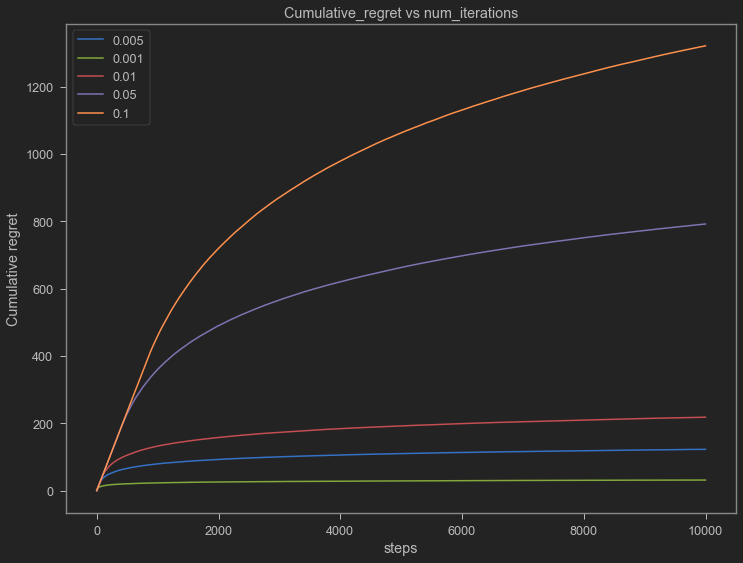

In [11]:
plt.figure(figsize=(12,9))
plt.title("Cumulative_regret vs num_iterations")
for keys in epsv_dict: 
    plt.plot(np.cumsum(epsv_dict[keys][0]),label=keys);
plt.legend();
plt.xlabel("steps");
plt.ylabel("Cumulative regret");
# plt.savefig("epsv1")

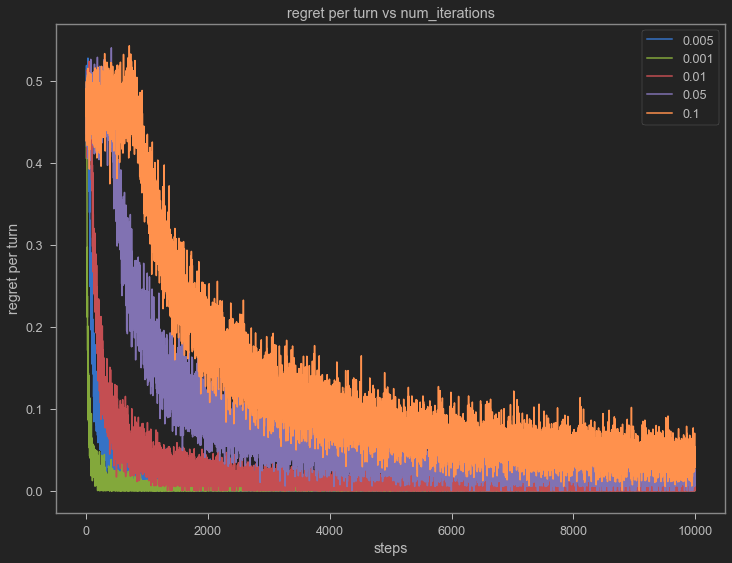

In [12]:
plt.figure(figsize=(12,9))
plt.title("regret per turn vs num_iterations")
for keys in epsv_dict: 
    plt.plot(epsv_dict[keys][0],label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("regret per turn");
# plt.savefig("epsv2")

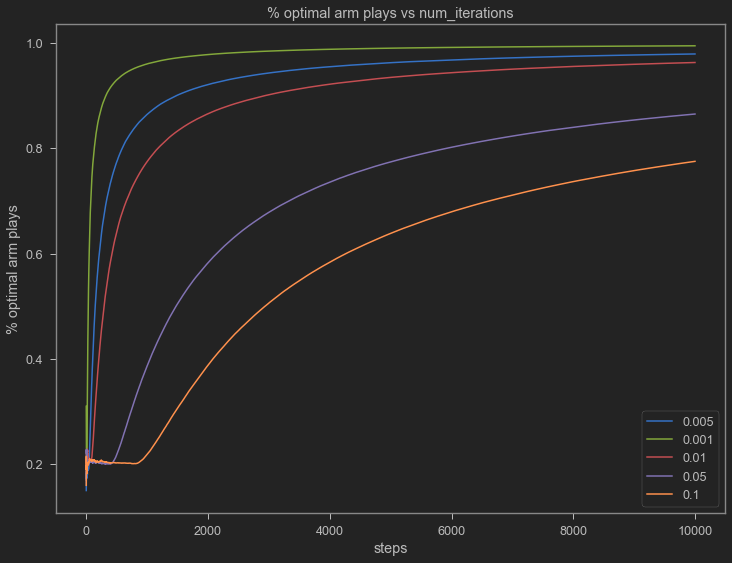

In [13]:
plt.figure(figsize=(12,9))
plt.title("% optimal arm plays vs num_iterations")
for keys in epsv_dict: 
    plt.plot(epsv_dict[keys][1],label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("% optimal arm plays");
# plt.savefig("epsv3")

# UCB

In [14]:
class UCB(object):
    def __init__(self,n):
        self.num_iter = n
    
    def update_emp_mean(self,emp_mean,reward,num):
        emp_mean += (reward - emp_mean)/(num+1)
        return emp_mean
        
    def run_experiment(self,emp_mean,opt_arm,opt_exp_val,exp_val):
        regret_per_turn = []
        opt_arm_plays = 0
        per_opt_arm_plays = []
        no_of_pulls = np.ones(len(emp_mean))
        for iters in range(self.num_iter):
            action = np.argmax(emp_mean + np.sqrt(2*np.log(iters+1)/no_of_pulls)) 
            rew = bernoulli(exp_val[action])
            emp_mean[action] = self.update_emp_mean(emp_mean[action],rew,no_of_pulls[action])
            regret_per_turn.append(opt_exp_val - exp_val[action])
            no_of_pulls[action] = no_of_pulls[action] + 1
            if action == opt_arm:
                opt_arm_plays += 1
            per_opt_arm_plays.append(opt_arm_plays/(iters+1))
            
        return(regret_per_turn,per_opt_arm_plays)

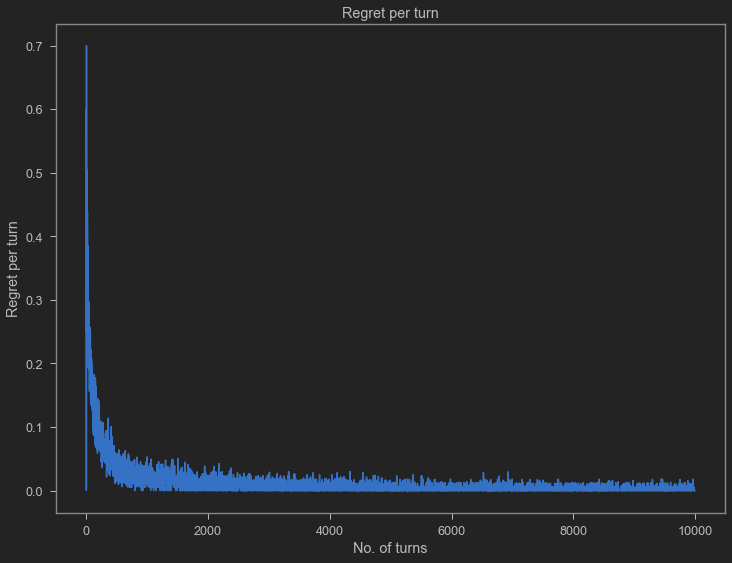

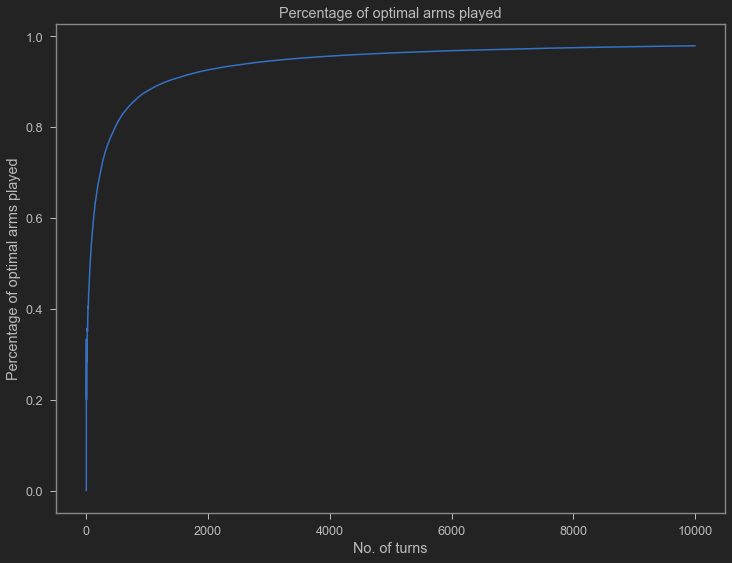

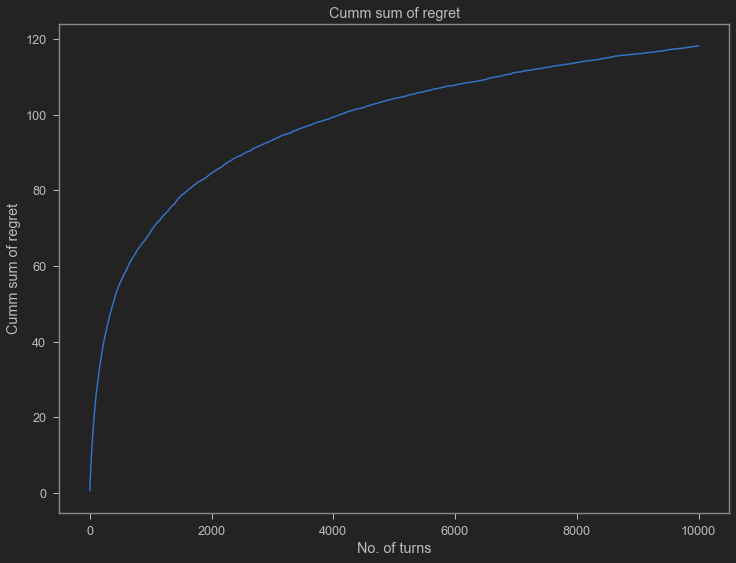

In [15]:
rpt_ucb = np.zeros(10000)
poap_ucb = np.zeros(10000)
for sims in range(100):
    bandit = bernoulli_bandits(arms,true_exp_val)
    ucb = UCB(10000)
    tmp1,tmp2 = ucb.run_experiment(bandit.emp_mean,bandit.opt_arm,bandit.opt_exp_val,bandit.exp_val)
    rpt_ucb = np.add(rpt_ucb,tmp1)
    poap_ucb = np.add(poap_ucb,tmp2)
rpt_ucb=rpt_ucb/100;
poap_ucb=poap_ucb/100;

plt.figure(figsize=(12,9))
plt.plot(rpt_ucb)
plt.title("Regret per turn")
plt.xlabel("No. of turns")
plt.ylabel("Regret per turn")
plt.show()

plt.figure(figsize=(12,9))
plt.plot(poap_ucb)
plt.title("Percentage of optimal arms played")
plt.xlabel("No. of turns")
plt.ylabel("Percentage of optimal arms played")
plt.show()

plt.figure(figsize=(12,9))
plt.plot(np.cumsum(rpt_ucb))
plt.title("Cumm sum of regret")
plt.xlabel("No. of turns")
plt.ylabel("Cumm sum of regret")
plt.show()

# Softmax with different temperature (tau) parameters

In [16]:
class softmax_temp(object):
    def __init__(self,tau,num_iter,num_arms):
        self.tau = tau
        self.num_iter = num_iter
        self.num_arms_picks = np.zeros(num_arms)
    
    def update_emp_mean(self,emp_mean,reward,arm):
        self.num_arms_picks[arm] += 1;
        emp_mean += (reward - emp_mean)/self.num_arms_picks[arm]
        return emp_mean
        
    def run_experiment(self,emp_mean,opt_arm,opt_exp_val,exp_val):
        regret_per_turn = []
        opt_arm_plays = 0
        per_opt_arm_plays = []
        
        for iters in range(self.num_iter):
            action = np.random.choice(len(emp_mean),p=softmax_tau(emp_mean,self.tau))
            rew = bernoulli(exp_val[action])
            emp_mean[action] = self.update_emp_mean(emp_mean[action],rew,action)
            regret_per_turn.append(opt_exp_val - exp_val[action])
            
            if action == opt_arm:
                opt_arm_plays += 1
            per_opt_arm_plays.append(opt_arm_plays/(iters+1))
            
        return(regret_per_turn,per_opt_arm_plays)

In [17]:
tau_arr = [0.1,0.05,0.01,0.005]
soft_dict={};
for tau in tau_arr:
    rpt = np.zeros(10000)
    poap = np.zeros(10000)
    for sims in range(100):
        bandit = bernoulli_bandits(arms,true_exp_val)
        soft = softmax_temp(tau,10000,arms)
        tmp1,tmp2 = soft.run_experiment(bandit.emp_mean,bandit.opt_arm,bandit.opt_exp_val,bandit.exp_val)
        rpt = np.add(rpt,tmp1)
        poap = np.add(poap,tmp2)
    soft_dict[tau] = [rpt/100,poap/100];

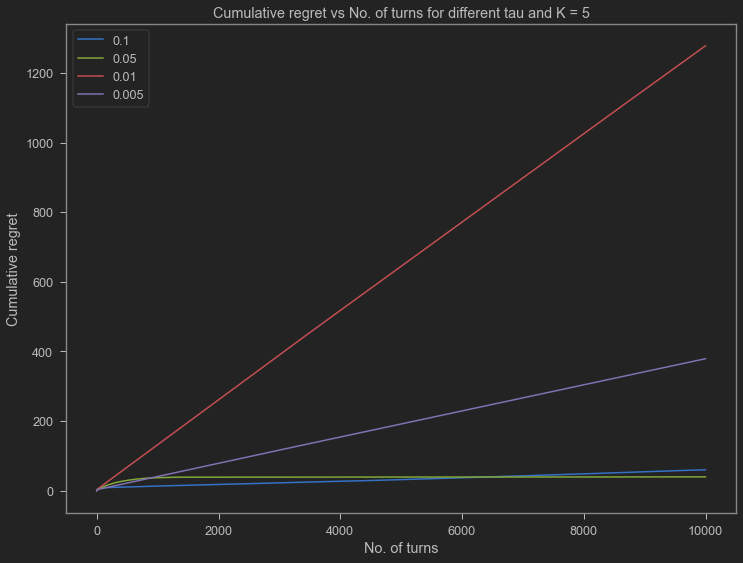

In [18]:
plt.figure(figsize=(12,9))
for keys in soft_dict:
    plt.plot(np.cumsum(soft_dict[keys][0]),label=keys);
plt.legend();
plt.title("Cumulative regret vs No. of turns for different tau and K = "+str(arms));
plt.xlabel("No. of turns");
plt.ylabel("Cumulative regret");
# plt.savefig("soft_cr"+str(arms)+".png")

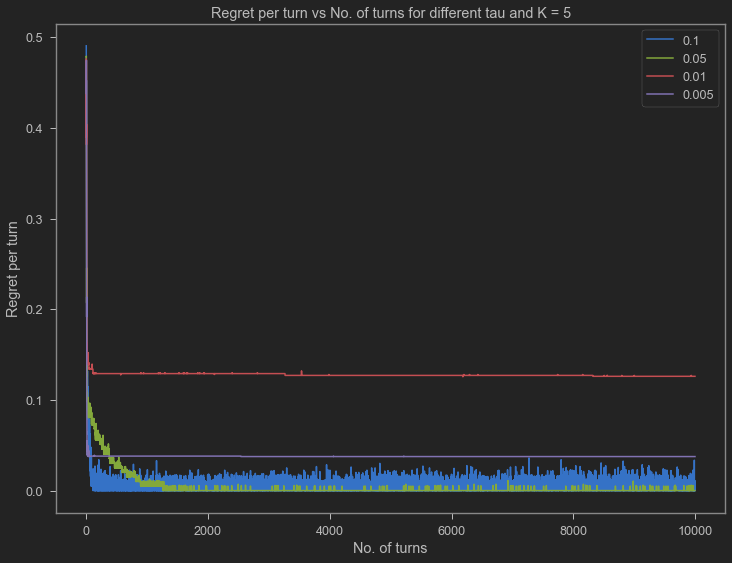

In [19]:
plt.figure(figsize=(12,9))
for keys in soft_dict:
    plt.plot(soft_dict[keys][0],label=keys);
plt.legend();
plt.xlabel("No. of turns");
plt.ylabel("Regret per turn");
plt.title("Regret per turn vs No. of turns for different tau and K = "+str(arms));
# plt.savefig("soft_rpt"+str(arms)+".png")

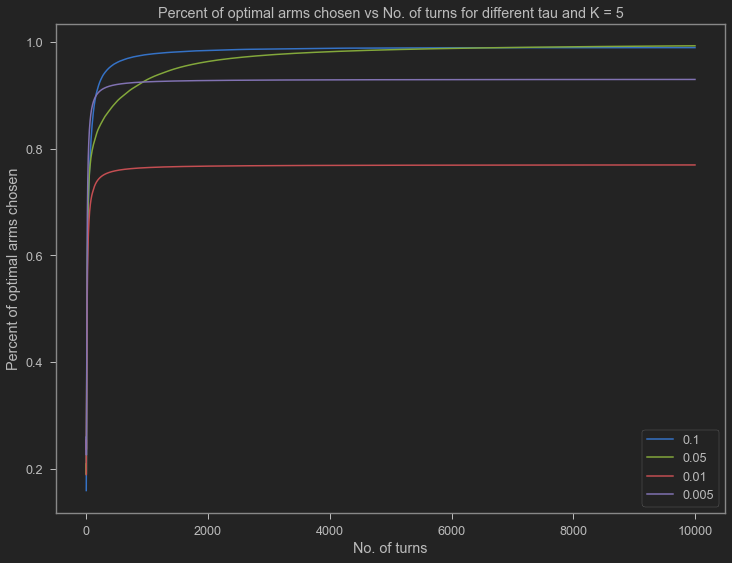

In [20]:
plt.figure(figsize=(12,9))
for keys in soft_dict:
    plt.plot(soft_dict[keys][1],label=keys);
plt.legend();
plt.title("Percent of optimal arms chosen vs No. of turns for different tau and K = "+str(arms));
plt.xlabel("No. of turns");
plt.ylabel("Percent of optimal arms chosen");
# plt.savefig("soft_poac"+str(arms)+".png")

# Thompson sampling

In [21]:
class thompson(object):
    def __init__(self,num_iter):
        self.num_iter = num_iter
        
    def run_experiment(self,opt_arm,opt_exp_val,exp_val,a,b):
        regret_per_turn = []
        opt_arm_plays = 0
        per_opt_arm_plays = []
        
        for iters in range(self.num_iter):
            action = np.argmax(np.random.beta(a,b))
            
            rew = bernoulli(exp_val[action])
            a[action]+= rew
            b[action]+= (1-rew)
            regret_per_turn.append(opt_exp_val - exp_val[action])
            
            if action == opt_arm:
                opt_arm_plays += 1
            per_opt_arm_plays.append(opt_arm_plays/(iters+1))
            
        return(regret_per_turn,per_opt_arm_plays)

In [22]:
rpt_t = np.zeros(10000)
poap_t = np.zeros(10000)

for sims in range(100):
    bandit = bernoulli_bandits(arms,true_exp_val)
    thomp = thompson(10000)
    
    tmp1,tmp2 = thomp.run_experiment(bandit.opt_arm,bandit.opt_exp_val,bandit.exp_val,bandit.a,bandit.b)
    rpt_t = np.add(rpt_t,tmp1)
    poap_t = np.add(poap_t,tmp2)
rpt_t/=100
poap_t/=100

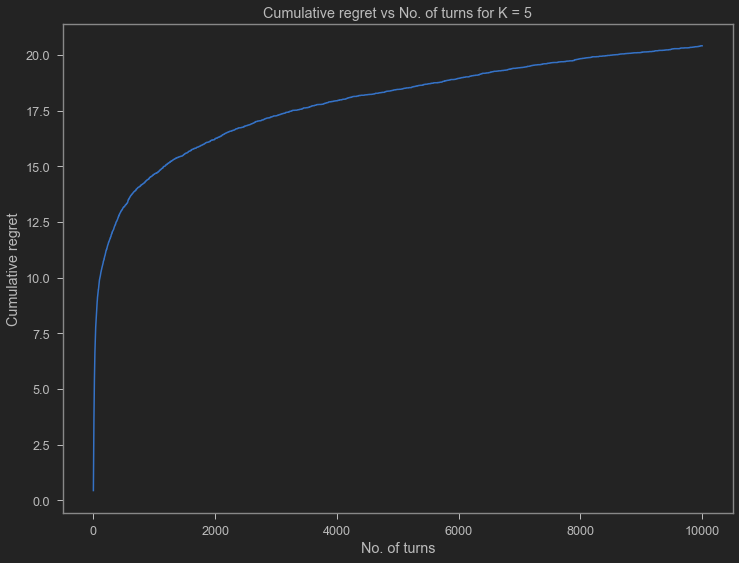

In [23]:
plt.figure(figsize=(12,9))
plt.plot(np.cumsum(rpt_t));
plt.title("Cumulative regret vs No. of turns for K = "+str(arms));
plt.xlabel("No. of turns");
plt.ylabel("Cumulative regret");
# plt.savefig("thomp_cr"+str(arms)+".png")

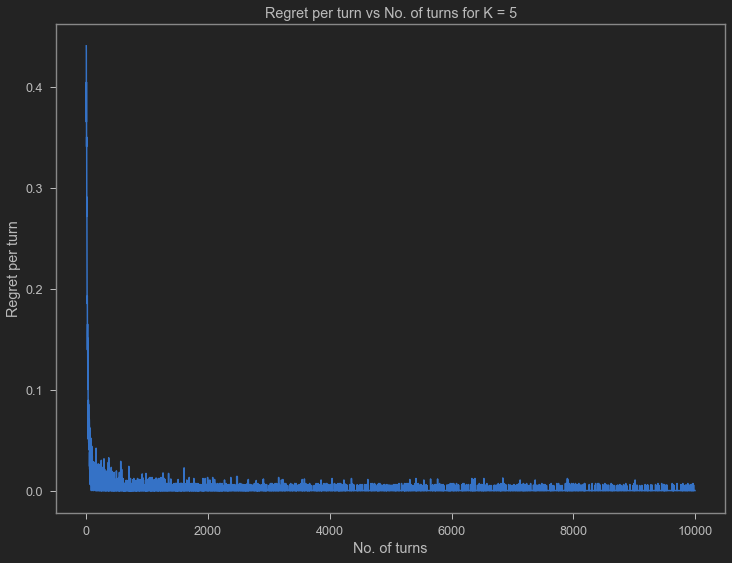

In [24]:
plt.figure(figsize=(12,9))
plt.plot(rpt_t);
plt.xlabel("No. of turns");
plt.ylabel("Regret per turn");
plt.title("Regret per turn vs No. of turns for K = "+str(arms));
# plt.savefig("thomp_rpt"+str(arms)+".png")

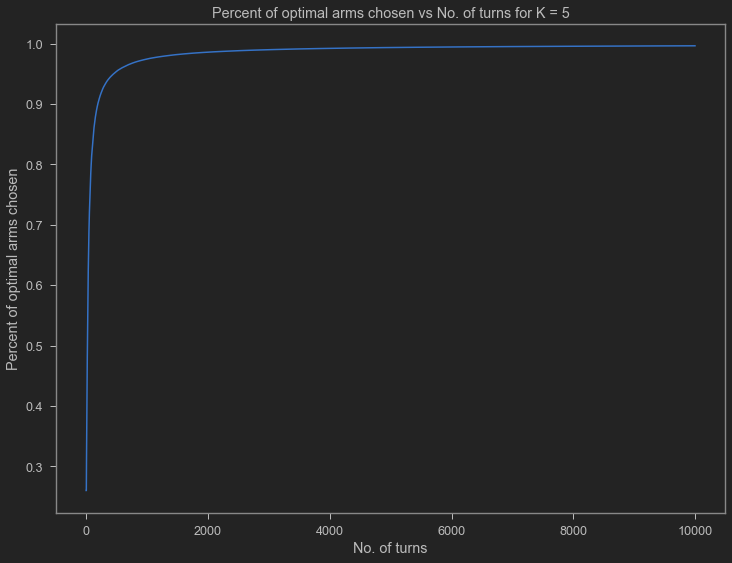

In [25]:
plt.figure(figsize=(12,9))
plt.plot(poap_t);
plt.title("Percent of optimal arms chosen vs No. of turns for K = "+str(arms));
plt.xlabel("No. of turns");
plt.ylabel("Percent of optimal arms chosen");
# plt.savefig("thomp_poac"+str(arms)+".png")

# Reinforce Algorithm with baseline

In [26]:
class reinforce_with_baseline(object):
    def __init__(self,n,num_arms,alpha):
        self.num_iter = n
        self.k = num_arms
#         self.beta = beta
        self.alpha = alpha
        self.policy_pref = np.zeros(self.k)
        self.prob_est = self.softmax(self.policy_pref)
    
    def softmax(self,policy_pref):
        return np.exp(self.policy_pref)/np.sum(np.exp(self.policy_pref))
     
    def choose_arm(self,prob):
        return np.random.choice(len(prob),p=prob)
    
    def update_prob_est(self,rew,arm,rew_avg):
        self.policy_pref[arm] += self.alpha*(rew-rew_avg)*(1-self.prob_est[arm])
        for arms in range(self.k):
            if arms != arm:
                self.policy_pref[arms] += -self.alpha*(rew-rew_avg)*(self.prob_est[arms])
        self.prob_est = self.softmax(self.policy_pref)
    
    def run_experiment(self,exp_val,opt_arm,opt_exp_val):
        regret_per_turn = []
        opt_arm_plays = 0
        per_opt_arm_plays = []
        rew_avg = 0
        
        for iters in range(self.num_iter):
            action = self.choose_arm(self.prob_est)
                
            rew = bernoulli(exp_val[action])

            rew_avg += (rew-rew_avg)/(iters+1)
            self.update_prob_est(rew,action,rew_avg)
            
            regret_per_turn.append(opt_exp_val - exp_val[action])
            
            if action == opt_arm:
                opt_arm_plays += 1
            per_opt_arm_plays.append(opt_arm_plays/(iters+1))
            
        return(regret_per_turn,per_opt_arm_plays)

In [27]:
alpha = [0.01,0.05,0.1,0.4,0.7]
rfwithb_dict = {}

for vals in alpha:
    rpt_rfwithb = np.zeros(10000)
    poap_rfwithb = np.zeros(10000)
    for sims in range(100):
        bandit = bernoulli_bandits(arms,true_exp_val)
        rfwithb = reinforce_with_baseline(10000,bandit.num_arms,vals)

        tmp1,tmp2 = rfwithb.run_experiment(bandit.exp_val,bandit.opt_arm,bandit.opt_exp_val)
        rpt_rfwithb = np.add(rpt_rfwithb,tmp1)
        poap_rfwithb = np.add(poap_rfwithb,tmp2)
        
    rfwithb_dict[vals] = [rpt_rfwithb/100,poap_rfwithb/100]

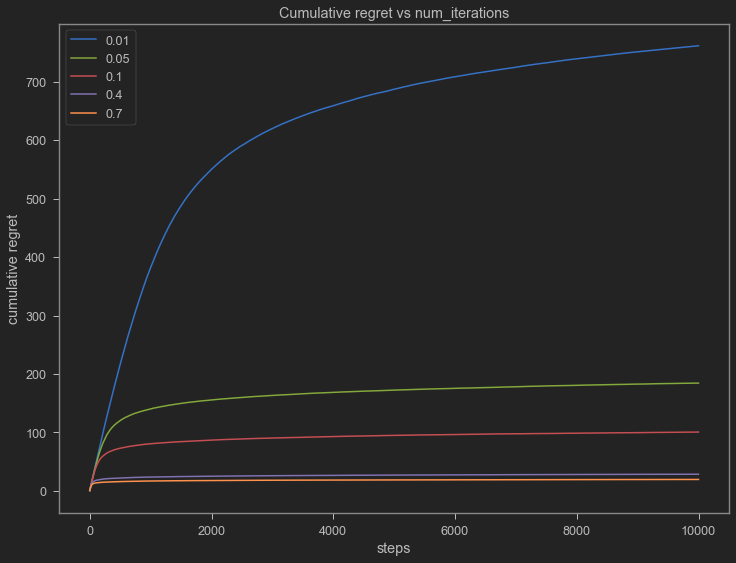

In [28]:
plt.figure(figsize=(12,9))
plt.title("Cumulative regret vs num_iterations")
for keys in rfwithb_dict: 
    plt.plot(np.cumsum(rfwithb_dict[keys][0]),label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("cumulative regret");
# plt.savefig("rwithb1")

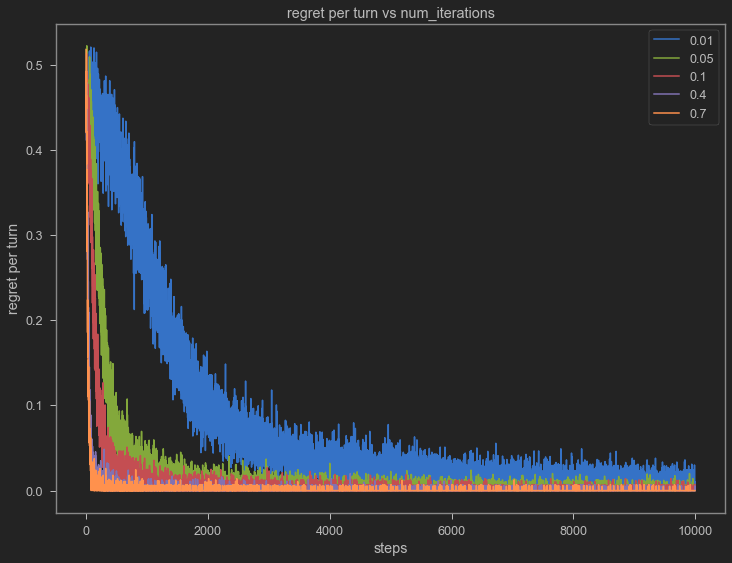

In [29]:
plt.figure(figsize=(12,9))
plt.title("regret per turn vs num_iterations")
for keys in rfwithb_dict: 
    plt.plot(rfwithb_dict[keys][0],label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("regret per turn");
# plt.savefig("rwithb2")

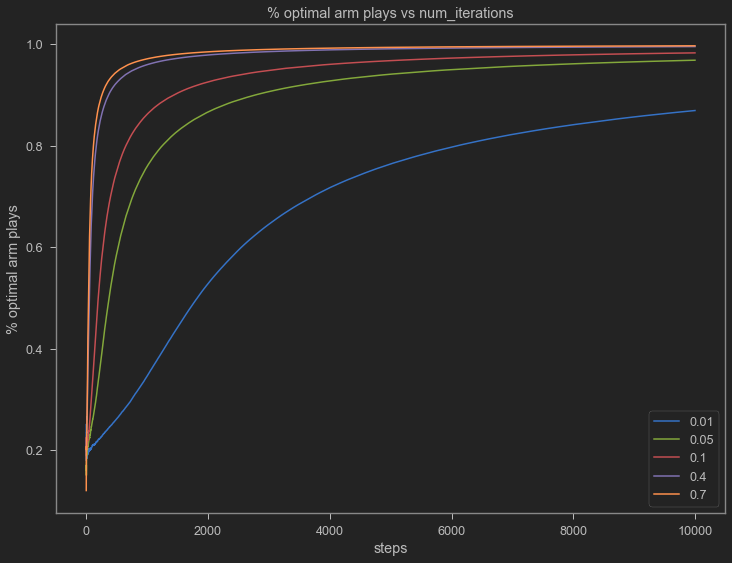

In [30]:
plt.figure(figsize=(12,9))
plt.title("% optimal arm plays vs num_iterations")
for keys in rfwithb_dict: 
    plt.plot(rfwithb_dict[keys][1],label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("% optimal arm plays");
# plt.savefig("rwithb3")

# Reinforce Algorithm without baseline

In [31]:
class reinforce_wout_baseline(object):
    def __init__(self,n,num_arms,alpha):
        self.num_iter = n
        self.k = num_arms
        self.alpha = alpha
        self.policy_pref = np.zeros(self.k)
        self.prob_est = self.softmax(self.policy_pref)
    
    def softmax(self,policy_pref):
        return np.exp(self.policy_pref)/np.sum(np.exp(self.policy_pref))
     
    def choose_arm(self,prob):
        return np.random.choice(len(prob),p=prob)
    
    def update_prob_est(self,rew,arm):
        self.policy_pref[arm] += self.alpha*(rew)*(1-self.prob_est[arm])
        for arms in range(self.k):
            if arms != arm:
                self.policy_pref[arms] += -self.alpha*(rew)*(self.prob_est[arms])
        self.prob_est = self.softmax(self.policy_pref)
    
    def run_experiment(self,exp_val,opt_arm,opt_exp_val):
        regret_per_turn = []
        opt_arm_plays = 0
        per_opt_arm_plays = []
        
        for iters in range(self.num_iter):
            action = self.choose_arm(self.prob_est)
                
            rew = bernoulli(exp_val[action])
            self.update_prob_est(rew,action)
            
            regret_per_turn.append(opt_exp_val - exp_val[action])
            
            if action == opt_arm:
                opt_arm_plays += 1
            per_opt_arm_plays.append(opt_arm_plays/(iters+1))
            
        return(regret_per_turn,per_opt_arm_plays)

In [32]:
alpha = [0.01,0.05,0.1,0.4,0.7]
rfwoutb_dict = {}

for vals in alpha:
    rpt_rfwoutb = np.zeros(10000)
    poap_rfwoutb = np.zeros(10000)
    for sims in range(100):
        bandit = bernoulli_bandits(arms,true_exp_val)
        rfwoutb = reinforce_wout_baseline(10000,bandit.num_arms,vals)

        tmp1,tmp2 = rfwoutb.run_experiment(bandit.exp_val,bandit.opt_arm,bandit.opt_exp_val)
        rpt_rfwoutb = np.add(rpt_rfwoutb,tmp1)
        poap_rfwoutb = np.add(poap_rfwoutb,tmp2)
        
    rfwoutb_dict[vals] = [rpt_rfwoutb/100,poap_rfwoutb/100]

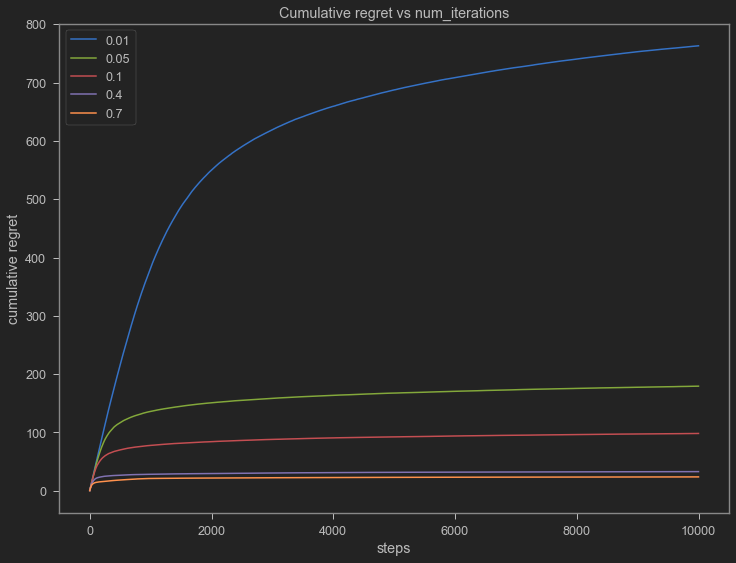

In [33]:
plt.figure(figsize=(12,9))
plt.title("Cumulative regret vs num_iterations")
for keys in rfwoutb_dict: 
    plt.plot(np.cumsum(rfwoutb_dict[keys][0]),label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("cumulative regret");
# plt.savefig("rwoutb1")

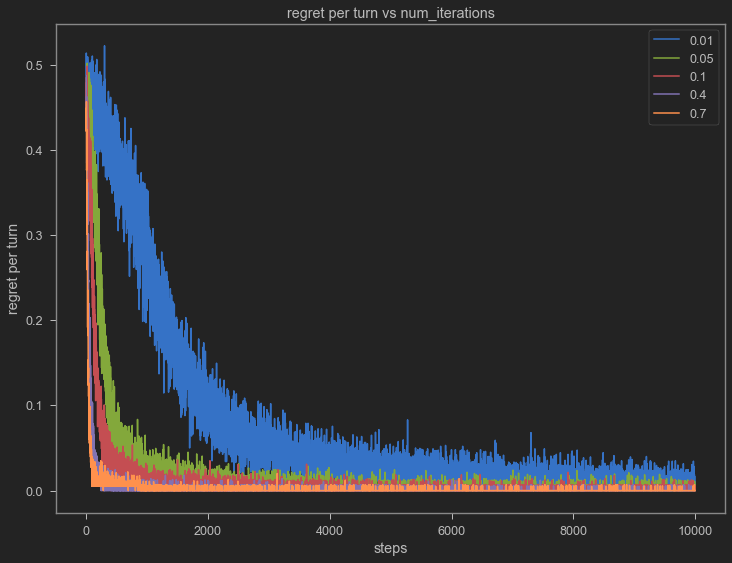

In [34]:
plt.figure(figsize=(12,9))
plt.title("regret per turn vs num_iterations")
for keys in rfwoutb_dict: 
    plt.plot(rfwoutb_dict[keys][0],label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("regret per turn");
# plt.savefig("rwoutb2")

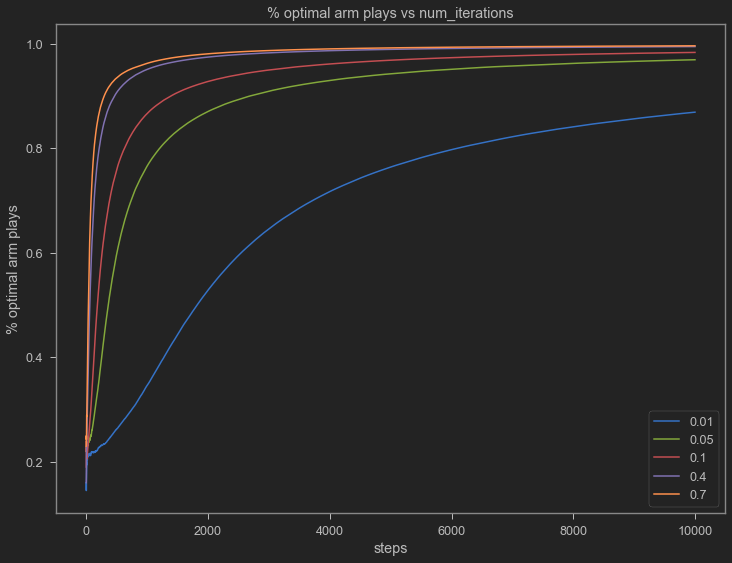

In [35]:
plt.figure(figsize=(12,9))
plt.title("% optimal arm plays vs num_iterations")
for keys in rfwoutb_dict: 
    plt.plot(rfwoutb_dict[keys][1],label=keys);
plt.legend()
plt.xlabel("steps");
plt.ylabel("% optimal arm plays");
# plt.savefig("rwoutb3")

# Comparison

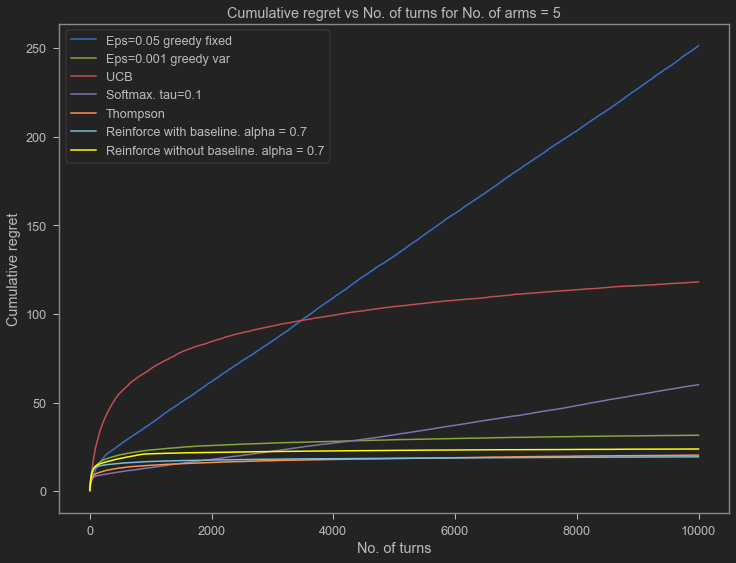

In [42]:
plt.figure(figsize=(12,9))
plt.plot(np.cumsum(epsf_dict[0.05][0]),label="Eps=0.05 greedy fixed");
plt.plot(np.cumsum(epsv_dict[0.001][0]),label="Eps=0.001 greedy var");
plt.plot(np.cumsum(rpt_ucb),label="UCB");
plt.plot(np.cumsum(soft_dict[0.1][0]),label="Softmax. tau=0.1");
plt.plot(np.cumsum(rpt_t),label="Thompson");
plt.plot(np.cumsum(rfwithb_dict[0.7][0]),label="Reinforce with baseline. alpha = 0.7");
plt.plot(np.cumsum(rfwoutb_dict[0.7][0]),label="Reinforce without baseline. alpha = 0.7",c='yellow');
plt.title("Cumulative regret vs No. of turns for No. of arms = "+str(arms));
plt.xlabel("No. of turns");
plt.ylabel("Cumulative regret");
plt.legend();
plt.savefig("crc"+str(arms))

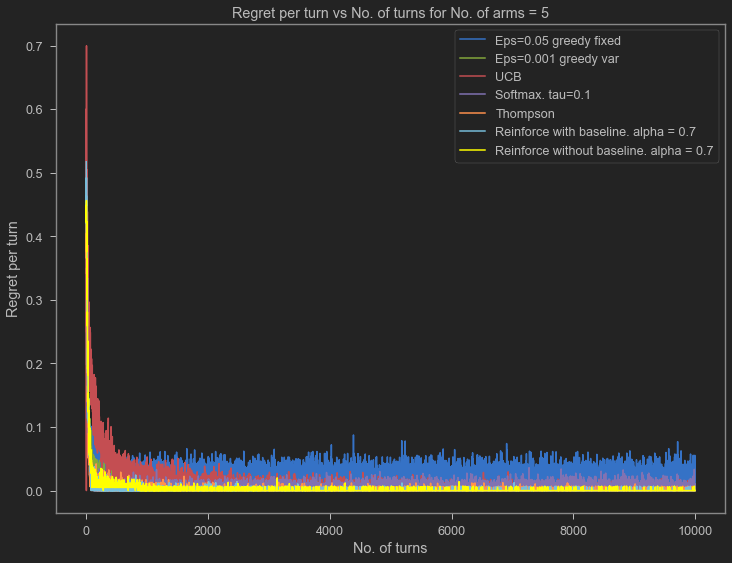

In [43]:
plt.figure(figsize=(12,9))
plt.plot(epsf_dict[0.05][0],label="Eps=0.05 greedy fixed");
plt.plot(epsv_dict[0.001][0],label="Eps=0.001 greedy var");
plt.plot(rpt_ucb,label="UCB");
plt.plot(soft_dict[0.1][0],label="Softmax. tau=0.1");
plt.plot(rpt_t,label="Thompson");
plt.plot(rfwithb_dict[0.7][0],label="Reinforce with baseline. alpha = 0.7");
plt.plot(rfwoutb_dict[0.7][0],label="Reinforce without baseline. alpha = 0.7",c='yellow');
plt.xlabel("No. of turns");
plt.ylabel("Regret per turn");
plt.title("Regret per turn vs No. of turns for No. of arms = "+str(arms));
plt.legend();
plt.savefig("rptc"+str(arms))

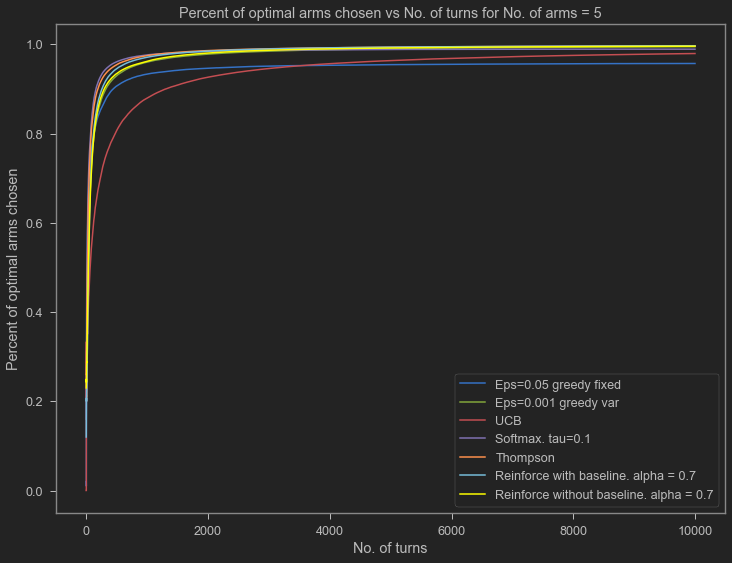

In [44]:
plt.figure(figsize=(12,9))
plt.plot(epsf_dict[0.05][1],label="Eps=0.05 greedy fixed");
plt.plot(epsv_dict[0.001][1],label="Eps=0.001 greedy var");
plt.plot(poap_ucb,label="UCB");
plt.plot(soft_dict[0.1][1],label="Softmax. tau=0.1");
plt.plot(poap_t,label="Thompson");
plt.plot(rfwithb_dict[0.7][1],label="Reinforce with baseline. alpha = 0.7");
plt.plot(rfwoutb_dict[0.7][1],label="Reinforce without baseline. alpha = 0.7",c='yellow');
plt.title("Percent of optimal arms chosen vs No. of turns for No. of arms = "+str(arms));
plt.xlabel("No. of turns");
plt.ylabel("Percent of optimal arms chosen");
plt.legend();
plt.savefig("poapc"+str(arms))

In [52]:
np.sum(epsf_dict[0.05][0])

251.39300000000006

In [53]:
np.sum(epsv_dict[0.001][0])

31.633000000000006

In [54]:
np.sum(rpt_ucb)

118.18350000000001

In [55]:
np.sum(soft_dict[0.1][0])

60.125

In [56]:
np.sum(rpt_t)

20.4155

In [57]:
np.sum(rfwithb_dict[0.7][0])

19.446500000000007

In [58]:
np.sum(rfwoutb_dict[0.7][0])

23.867500000000003